In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import  layers,Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import  Dropout



In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
trainPath="/content/drive/MyDrive/Deep Learning/chest_xray_dataset/train"
testPath="/content/drive/MyDrive/Deep Learning/chest_xray_dataset/test"


train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,         
    zoom_range=0.5,
    horizontal_flip=True,
    validation_split=0.1
)
val_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.1) 
test_datagen=ImageDataGenerator(rescale=1./255)


trainDataGen=ImageDataGenerator(
    rescale=1./224,
    validation_split=0.1
)

testDataGen=ImageDataGenerator(rescale=1./224)

trainGen=trainDataGen.flow_from_directory(
    trainPath,
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    subset='training'
)

valGen=trainDataGen.flow_from_directory(
    trainPath,
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    subset='validation')

testGen=testDataGen.flow_from_directory(
    testPath,
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=1)

Found 4711 images belonging to 3 classes.
Found 521 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [5]:
#train klasörü
print(trainGen.class_indices)
print("")
normal,bacteria,virus=(0,0,0)
for i in trainGen.classes:
  if i ==0:
    normal+=1
  if i ==1:
    bacteria+=1
  if i == 2:
    virus+=1
print("trainGen:","normal:",normal," bacteria:",bacteria," virus:",virus,"toplam:",normal+bacteria+virus)

#test klasörü
normal,bacteria,virus=(0,0,0)
for i in testGen.classes:
  if i ==0:
    normal+=1
  if i ==1:
    bacteria+=1
  if i == 2:
    virus+=1
print(" testGen:","normal:",normal,"  bacteria:",bacteria,"  virus:",virus," toplam:",normal+bacteria+virus)

#val klasörü
normal,bacteria,virus=(0,0,0)
for i in valGen.classes:
  if i ==0:
    normal+=1
  if i ==1:
    bacteria+=1
  if i == 2:
    virus+=1
print("  valGen:","normal:",normal,"  bacteria:",bacteria,"  virus:",virus," toplam:",normal+bacteria+virus)

{'NORMAL': 0, 'PNEUMONIA_BACTERIA': 1, 'PNEUMONIA_VIRUS': 2}

trainGen: normal: 1215  bacteria: 2285  virus: 1211 toplam: 4711
 testGen: normal: 234   bacteria: 242   virus: 148  toplam: 624
  valGen: normal: 134   bacteria: 253   virus: 134  toplam: 521


In [29]:
# Vgg16 Transfer learning

base_model=VGG16(input_shape=(224,244,3),
                 include_top=False,
                 weights='imagenet',
                 )
base_model.trainable=False

for layer in base_model.layers[4:]:
  layer.trainable=True

x=layers.Flatten()(base_model.output)
x=layers.Dense(512,activation='relu')(x)
x=layers.Dropout(0.5)(x)
x=layers.Dense(256,activation='relu')(x)
x=layers.Dropout(0.3)(x)

out=layers.Dense(3,activation='softmax')(x)


model=Model(inputs=base_model.inputs,outputs=out)

model.summary()

for layer in model.layers:
  print(layer.name," ",layer.trainable)



model.compile(loss="categorical_crossentropy",optimizer="sgd", metrics=["accuracy"])


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 61, 128)       0  

In [30]:
history=model.fit(
    trainGen,
    steps_per_epoch=trainGen.samples//16,
    validation_data=valGen,
    epochs=10,
    validation_steps=valGen.samples//16
)

Epoch 1/10
294/294 [==============================] - 74s 250ms/step - loss: 1.0003 - accuracy: 0.5159 - val_loss: 0.7336 - val_accuracy: 0.6270
Epoch 2/10
294/294 [==============================] - 73s 247ms/step - loss: 0.6801 - accuracy: 0.6758 - val_loss: 0.4896 - val_accuracy: 0.7578
Epoch 3/10
294/294 [==============================] - 73s 248ms/step - loss: 0.5354 - accuracy: 0.7476 - val_loss: 0.4087 - val_accuracy: 0.8555
Epoch 4/10
294/294 [==============================] - 73s 247ms/step - loss: 0.4776 - accuracy: 0.7857 - val_loss: 0.4384 - val_accuracy: 0.8516
Epoch 5/10
294/294 [==============================] - 73s 246ms/step - loss: 0.4410 - accuracy: 0.7940 - val_loss: 0.3911 - val_accuracy: 0.8574
Epoch 6/10
294/294 [==============================] - 72s 246ms/step - loss: 0.4305 - accuracy: 0.8023 - val_loss: 0.3875 - val_accuracy: 0.8789
Epoch 7/10
294/294 [==============================] - 73s 247ms/step - loss: 0.4086 - accuracy: 0.8143 - val_loss: 0.3291 - val_ac

Text(0.5, 1.0, 'Accuracy Curves')

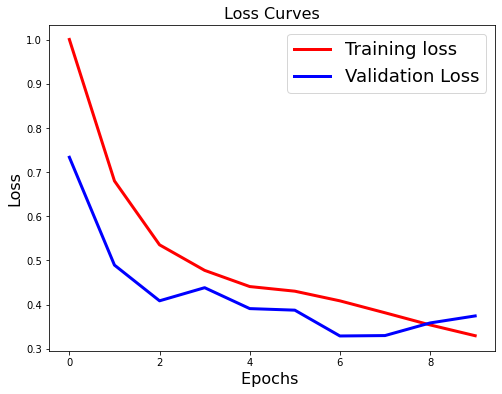

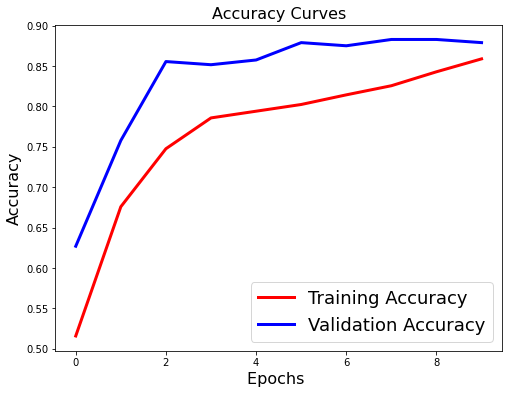

In [31]:
import matplotlib.pyplot as plt

#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [35]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


Y_pred = model.predict_generator(testGen, trainGen.samples // 1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testGen.classes, y_pred))
print('Classification Report')
target_names = ['Normal', 'Bacteria', 'Virus']
print(classification_report(testGen.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[ 55 119  60]
 [ 49 125  68]
 [ 26  95  27]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.42      0.24      0.30       234
    Bacteria       0.37      0.52      0.43       242
       Virus       0.17      0.18      0.18       148

    accuracy                           0.33       624
   macro avg       0.32      0.31      0.30       624
weighted avg       0.34      0.33      0.32       624

